## Prueba técnica ITC SA

In [157]:
#importamos librerias que vamos a utilizar
from google.colab import drive
drive.mount('/content/drive')

#importamos librerias

import zipfile
import os
from sklearn.model_selection import train_test_split
import cv2
import glob as gb
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomHeight, RandomWidth
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import keras

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
!ls /content/drive/MyDrive/ITC/

Beagle	Chihuahua  Chow  Great_dane  Rottweiler


## Descomprimimos el archivo

Al descargar el archivo, Google Drive comprimió todo en una carpeta, asi que lo descomprimimos para poder acceder a las imagenes.

Una vez extraido, borré manualmente el zip y la carpeta 'French_bulldogs', ya que no forman parte del set de entrenamiento.

In [ ]:
# Defino variables

zip = '/content/drive/MyDrive/ITC/dogs.zip'
extracted_zip = '/content/drive/MyDrive/ITC'

# Descomprimir el archivo ZIP

with zipfile.ZipFile(zip, 'r') as zip_ref:
    zip_ref.extractall(extracted_zip)

#Pre Procesamiento de imagenes

Pre-procesamos imagenes, dandole un tamaño concreto (180x180), y tambien creamos un diccionario con las distintas razas que va a predecir el modelo. En la lista X, asignamos las imagenes, y en la lista Y las etiquetas.


In [159]:
#ruta a la carpeta que contiene las subcarpetas de cada raza

data_dir = "/content/drive/MyDrive/ITC"

#ingresamos parametros de normalizacion de las imagenes, para aumentar la accuracy y función de pérdida del modelo.

img_height = 180
img_width = 180

#listas para almacenar las imágenes (X), etiquetas (Y) y nombres de archivos (image_titles)

X = []
Y = []
image_titles = []

#creamos un diccionario que tiene un numero asignado a cada raza, para que sea mas facil hacer las predicciones y entrenar el modelo.

label_map = {}
for idx, folder_name in enumerate(os.listdir(data_dir)):
    label_map[folder_name] = idx

#recorre cada carpeta y cada imagen dentro de la carpeta, y guarda en X la imagen, en y la etiqueta y en image_titles, el titulo.

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        #leer y redimensionar la imagen
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_width, img_height))

        #agregar la imagen, la etiqueta y el nombre a las listas
        X.append(img)
        Y.append(label_map[folder_name])
        image_titles.append(img_name)


#chequeamos que la info este correcta

print("Etiquetas:", Y[:150])
print("Nombres de imágenes:", image_titles[:150])


Etiquetas: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Nombres de imágenes: ['n02112137_528.jpg', 'n02112137_517.jpg', 'n02112137_1687.jpg', 'n02112137_2319.jpg', 'n02112137_1976.jpg', 'n02112137_1401.jpg', 'n02112137_2028.jpg', 'n02112137_2058.jpg', 'n02112137_2290.jpg', 'n02112137_2020.jpg', 'n02112137_2181.jpg', 'n02112137_347.jpg', 'n02112137_1251.jpg', 'n02112137_1015.jpg', 'n02112137_1704.jpg', 'n02112137_2220.jpg', 'n02112137_1374.jpg', 'n02112137_1830.jpg', 'n02112137_2250.jpg', 'n02112137_1795.jpg', 'n02112137_2133.jpg', 'n02112137_1589.jpg', 'n02112137_112.jpg', 'n02112137_161

In [160]:
#chequeamos que los valores en el diccionario hayan quedado bien.
print(label_map)

{'Chow': 0, 'Beagle': 1, 'Great_dane': 2, 'Chihuahua': 3, 'Rottweiler': 4}


In [161]:
#vonvertimos las listas X e Y a arrays de numpy para que sean compatibles con el modelo que vamos a crear

X = np.array(X)
Y = np.array(Y)

In [162]:
#chequeamos que efectivamente el tamaño de la imagen quedo como queriamos para el array X (180*180) y chequemos que el nro de imagenes sea 150. Deberiamos obtener algo asi: (150,180,180,3). El 3 corresponde al RGB.

X.shape

(150, 180, 180, 3)

## Train test split

Usamos la funcion train_test_split para dividir nuestro dataset en train y test para luego entrenar el modelo.

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 42, test_size=0.2)

In [164]:
X_train.shape

(120, 180, 180, 3)

In [165]:
y_train.shape

(120,)

## Creación del modelo

Usaremos deep neural networks para entrenar el modelo.

Es importante destacar que el set de entrenamiento contiene solo 30 imagenes por raza, lo cual es muy poco. Entonces, para mejorar la accuracy y la funcion de perdida del modelo en train y test, y en consecuencia el modelo en general, usamos transfer learning para poder tener predicciones mucho mas precisas.

En transfer learning lo que se hace es tomar un modelo que ya lee imagenes, como ResNet50 y trasladar el aprendizaje de ese modelo a nuestro modelo.

In [166]:
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomHeight, RandomWidth
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import keras
from tensorflow import keras
from tensorflow.keras import layers

In [167]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

#creamos una data augmentation layer para mejorar la accuracy y la funcion de perdida del modelo y que haga mejores predicciones
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

#definimos la dimension de entrada del modelo
input_shape = (180, 180, 3)

#hacemos transfer learning cargando resnet
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
base_model.trainable = True

#descongelo las ultimas 30 capas para tener un modelo mas fino en la predicción
for layer in base_model.layers[:-30]:
    layer.trainable = False

#construimos el modelo con capas adicionales arriba de resnet50
model = models.Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,
    base_model,

    #capa de pooling para reducir dimensionalidad
    layers.GlobalAveragePooling2D(),

    #capas densas adicionales
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    #capa de salida para 5 clases porque tenemos 5 razas
    layers.Dense(5, activation='softmax')
])

#compilamos el modelo con tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

print(model.summary())


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_35 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 6, 6, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_18          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 15,008,261 (57.25 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

None


In [168]:
#seteamos callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [169]:
#entrenamos el modelo con 100 épocas
epochs = 150
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, callbacks=callbacks, validation_data=(X_test, y_test))


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 896ms/step - accuracy: 0.2315 - loss: 1.8941 - val_accuracy: 0.3333 - val_loss: 1.5449 - learning_rate: 1.0000e-04
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.3579 - loss: 1.4957 - val_accuracy: 0.6333 - val_loss: 1.0866 - learning_rate: 1.0000e-04
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.5031 - loss: 1.2476 - val_accuracy: 0.8333 - val_loss: 0.7766 - learning_rate: 1.0000e-04
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5860 - loss: 1.0741 - val_accuracy: 0.8333 - val_loss: 0.5563 - learning_rate: 1.0000e-04
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.6860 - loss: 0.8926 - val_accuracy: 0.8333 - val_loss: 0.4370 - learning_rate: 1.0000e-04
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.7071 - loss: 0.7899 - val_accuracy: 0.8333 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.8369

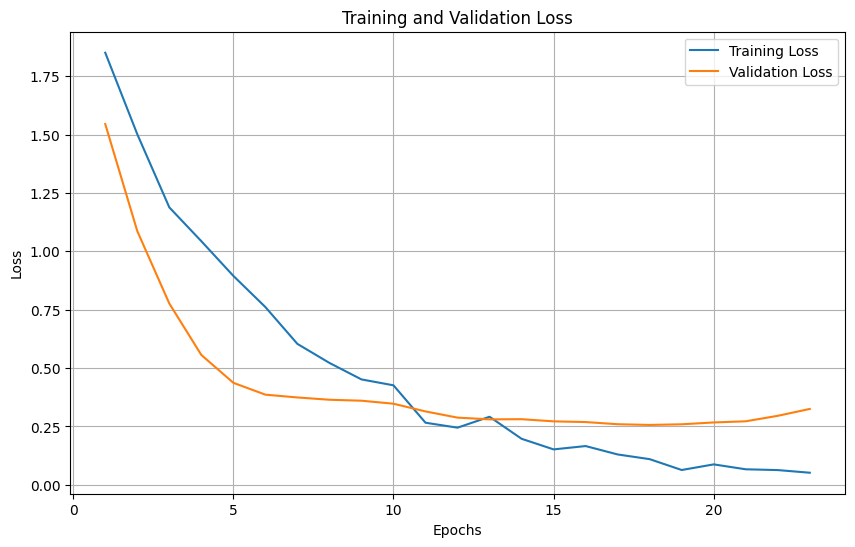

In [170]:
import matplotlib.pyplot as plt

#extraemos el historial de la funcion de perdida en train y test del modelo
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

#graficamos con matplotlib la funcion de perdida en train y test
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


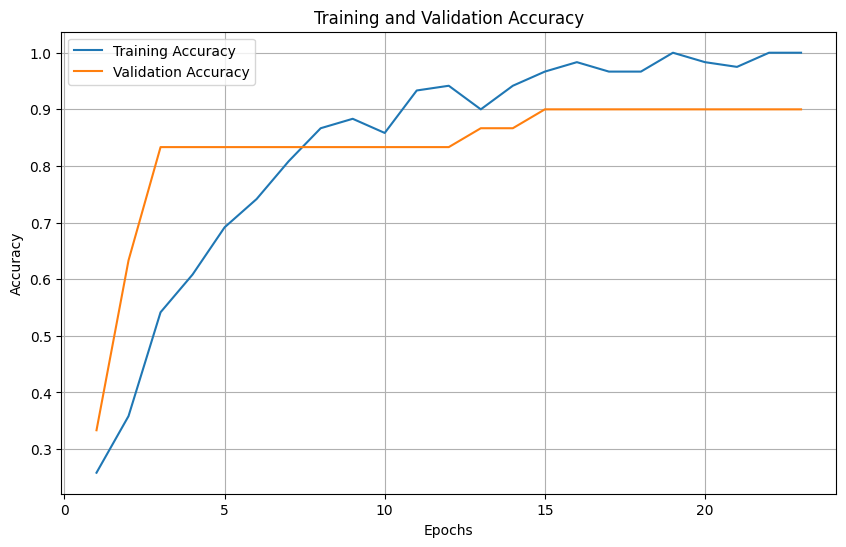

In [171]:
#extraemos el historial de la accuracy en train y test del modelo
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

#graficamos con matplotlib la accuracy en train y test
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


## Resultados de prediccion

Ahora, y para ir un poco mas alla de lo que se pide en la consigna, vamos a graficar fotos del set de entrenamiento junto con su prediccion y su etiqueta, para evaluar "a mano" que tan bien funciona el modelo.

In [134]:
import numpy as np
import matplotlib.pyplot as plt

#lista con los nombres de las razas que predice el modelo
class_names = ['Chow', 'Beagle', 'Great_dane', 'Chihuahua', 'Rottweiler']

#cantidad de imagenes a mostrar
num_images = 20

#creamos una cuadrícula de 4x5 para mostrar las imágenes
plt.figure(figsize=(15, 15))
for i in range(num_images):
    #seleccionamos una imagen y etiqueta del conjunto de entrenamiento
    sample_image = X_train[i]
    sample_label = y_train[i]

    #redimensionamos la imagen para que coincida con el formato de entrada del modelo
    sample_image_resized = np.expand_dims(sample_image, axis=0)

    #pedimos al modelo que haga la prediccion
    prediction = model.predict(sample_image_resized)
    predicted_class = class_names[np.argmax(prediction)]

    #mostramos las imagenes y la predicciones
    plt.subplot(4, 5, i + 1)
    plt.imshow(sample_image.astype("uint8"))
    plt.title(f"Predicción: {predicted_class}\nReal: {class_names[sample_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Testea el modelo con tus imagenes

Entonces, sabemos que el modelo solo predice algunas razas en especifico.

Pero... ¿qué pasa si le pasamos otra raza? El modelo va a predecir mal.

Entonces lo que hice en esta parte es establecer un umbral, si la foto que le pasen al modelo, el modelo la predice con una accuracy mayor a 0.9, entonces va a decir esa etiqueta.

Si la accuracy es menor que 0.98, va a ponerlo como "Other", indicando que se trata de otra raza.

Para usarlo, cargar las imagenes en memoria y luego cambiar la ruta de 'image_path' para poder testear el modelo correctamente.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


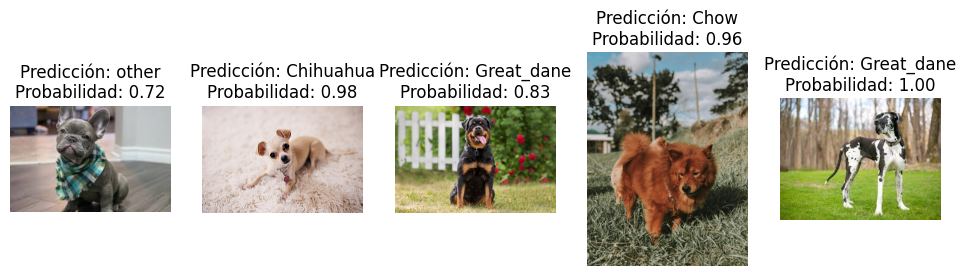

In [173]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

# Parámetros de preprocesamiento (igual que en el entrenamiento)
img_height = 180
img_width = 180
confidence_threshold = 0.8  # Ajusta este valor según tus necesidades

# Lista de rutas de imágenes (especifica las rutas a tus imágenes)
image_paths = [
    "/content/frenchie.jfif", "/content/pexels-wkn-992646-1933464.jpg", "/content/Rottweiler-Breed-Guide-Hero.jpg", '/content/pexels-mainesdtm-10891766.jpg', '/content/images.jfif']

# Crear una lista para almacenar las imágenes preprocesadas
images_array = []

# Cargar y preprocesar cada imagen con OpenCV
for image_path in image_paths:
    img = cv2.imread(image_path)  # Cargar la imagen
    img = cv2.resize(img, (img_width, img_height))  # Redimensionar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    images_array.append(img)

# Convertir la lista de imágenes a un array de NumPy con una dimensión adicional para el batch
images_array = np.array(images_array)

# Hacer las predicciones en todas las imágenes
predictions = model.predict(images_array)

# Mostrar cada imagen junto con su predicción y probabilidad
plt.figure(figsize=(12, 6))
for i, image_path in enumerate(image_paths):
    predicted_prob = np.max(predictions[i])  # Probabilidad de la clase predicha
    predicted_class_index = np.argmax(predictions[i])  # Índice de la clase predicha

    # Determinar la clase predicha con el umbral de confianza
    if predicted_prob < confidence_threshold:
        predicted_class = "other"
    else:
        predicted_class = list(label_map.keys())[predicted_class_index]

    # Cargar la imagen original para mostrarla
    img = Image.open(image_path)
    plt.subplot(1, len(image_paths), i + 1)
    plt.imshow(img)
    plt.title(f"Predicción: {predicted_class}\nProbabilidad: {predicted_prob:.2f}")
    plt.axis('off')

plt.show()
